In [1]:
import csv, os, glob, torch, time
from tqdm import tqdm
from utils.module import write_to_csv
from utils.autoencoder import VAE, vae_loss
from dataloader.dataset import UnlabeledDataset2, UnlabeledTransform2
import torch.utils.data as data
from utils.module import EarlyStopping
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [2]:
!nvidia-smi

Thu Nov  2 01:17:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla M60                      On  | 00000000:00:1B.0 Off |                    0 |
| N/A   33C    P8              14W / 150W |      0MiB /  7680MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
img_file_path = sorted(glob.glob('data/Train/images/*'))
img_file_path2 = sorted(glob.glob('data/original_split_resized/*'))
img_list = img_file_path + img_file_path2

train_dataset = UnlabeledDataset2(
    img_list, transform=UnlabeledTransform2(crop_size=32))
train_dataloader = data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

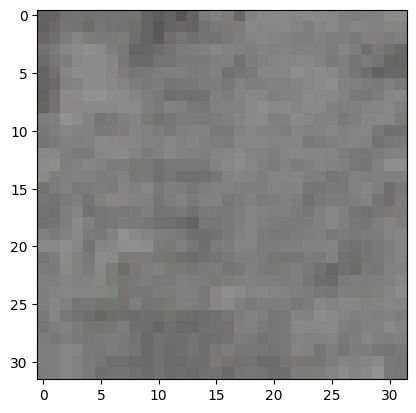

In [4]:
# train_dataloaderから次のバッチを取得
data_iterator = iter(train_dataloader)
imgs = next(data_iterator)

# バッチ内の最初の画像を取得
single_image = imgs[0]

# 画像をNumPy配列に変換
single_image = single_image.numpy()

# 画像をMatplotlibで表示
plt.imshow(single_image.transpose(1, 2, 0))  # チャンネルの次元を最後に移動
plt.show()


In [5]:
# VAEモデルのインスタンス化
model = VAE(latent_dim=2)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# オプティマイザを定義
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Epochs
num_epochs = 1000

In [ ]:
project = 'vae2'
earlystopping = EarlyStopping(patience=50)
os.makedirs('weights/'+ project, exist_ok=True)
model.load_state_dict(torch.load('weights/vae2/best.pth'))
model = model.to(device)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # モデルをトレーニングモードに設定
    running_loss = 0.0

    for inputs in tqdm(train_dataloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()  # 勾配をゼロに初期化
        outputs, mu, logvar, z = model(inputs)  # フォワードパス
        loss = vae_loss(outputs, inputs, mu, logvar)  # 損失を計算
        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータを更新
        running_loss += loss.item()
    
    epoch_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    with torch.no_grad():
        # Early Stopping
        earlystopping(epoch_train_loss)

        if earlystopping.early_stop:
            print("Early stopping")
            break
        if earlystopping.counter == 0:
            # download to CPU
            torch.save(model.to('cpu').state_dict(), 'weights/'+ project + '/best.pth')
            # upload to GPU
            model = model.to(device)

        print(f'Early Stopping Counter = {earlystopping.counter}')

torch.save(model.to('cpu').state_dict(), 'weights/'+ project + '/last.pth')

In [6]:
def encode(img_path, model):
    image = Image.open(img_path)

    # 画像を指定された形状にリサイズ
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()  # Tensorに変換
    ])
    image = transform(image)

    # バッチ次元を追加
    image = image.unsqueeze(0)
    
    output, _, _, z = model(image)
    
    return image, output, z

tensor([[-2.2845, -0.8192]])


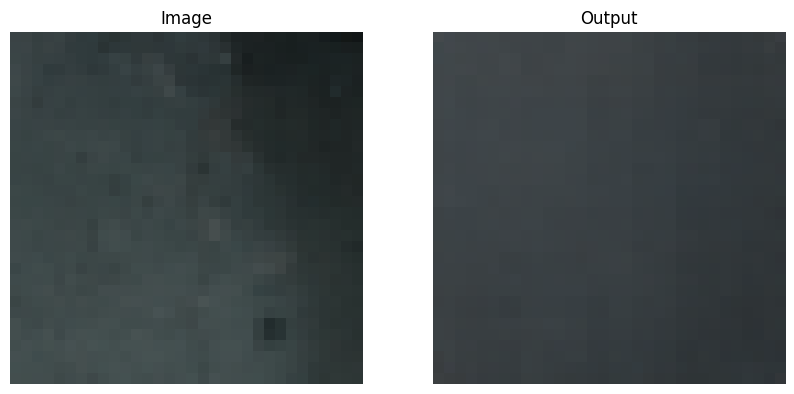

In [16]:
model = VAE(latent_dim=2)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('weights/vae2/best.pth'))
model = model.to(device)

img_path = "data/Train/images/Rissbilder_for_Florian_9S6A3136_91_118_3330_3239.jpg"
image, output, z = encode(img_path, model)
output = output.cpu().detach()
print(z.cpu().detach())

# 1行2列のサブプロットを作成
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# imageを表示
image = image.squeeze(0).numpy().transpose(1, 2, 0)  # バッチ次元を削除し、チャンネルの次元を最後に移動
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis('off')

# outputを表示
output = output.squeeze(0).numpy().transpose(1, 2, 0)  # バッチ次元を削除し、チャンネルの次元を最後に移動
axes[1].imshow(output)
axes[1].set_title("Output")
axes[1].axis('off')

plt.show()

In [ ]:
# データセットごとに、modelから潜在変数を出力して二次元空間にプロットする
y, mu, logvar, z = model.forward(x)